# New Na-22 notebook

June 2017

Cleaned up PhD thesis work


## Imports and settings

In [1]:
%run '../definitions.ipynb'
%run '../treemakers.ipynb'
%run '../Analysis_class.ipynb'

plt.style.use('latex_prl')
def plt_savefig(filename, folder='plots'):
    plt.savefig(os.path.join(folder, filename + '.pdf'))

/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/matplotlib/style/core.py:53: UserWarning: Style includes a parameter, 'backend', that is not related to style.  Ignoring
  "to style.  Ignoring".format(key))


In [2]:
# Toggle data location
local_data = False

In [3]:
if local_data:
    processed_data_path = '/home/erik/win/data/xams_run8/processed/low_pmt_gain/'
    minitree_path = '/home/erik/win/data/xams_run8/minitrees/'
else:
    processed_data_path = '/data/xenon/xams/run8/processed_v2/'
    minitree_path = '/data/xenon/xams/run8/minitrees/'

In [4]:
run_names_na = get_run_list(processed_data_path, '170323_155714', '170323_161452')

Run list contains 3 files


## Load data and first corrections

In [5]:
x = XAMSAnalysis(run_names_na, processed_data_path, minitree_path, include_NaI=True)

In [6]:
x.load()

Loaded 94009 (94.0 k) events.


In [7]:
x.corr_z(1.5, 1.73)

## Cuts

### At least one interaction

In [8]:
x.cut_interaction_exists()

Finite s1 selection: 5894 rows removed (93.73% passed)


### Threshold

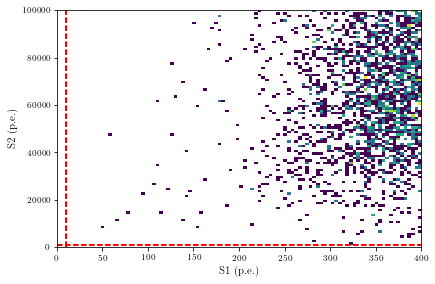

s1 above 10 selection: 0 rows removed (100.00% passed)
s2 above 1000 selection: 5 rows removed (99.99% passed)


In [9]:
x.cut_thresholds(s1_threshold=10, s2_threshold=1000,
    apply=True, plot=True, bins=100, norm=LogNorm(), range=((0, 400), (0, 100e3)))

### Single scatter S1

largest_other_s1 below 40 selection: 6154 rows removed (93.02% passed)


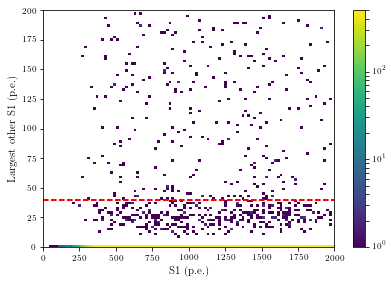

In [10]:
x.cut_largest_other_s1(largest_other_s1_max=40, plot=True, apply=True, bins=100, 
                       norm=LogNorm(), range=((0, 2000), (0, 200)), vmin=1, vmax=500)
plt.colorbar()
plt.show()

### Largest other S2

/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


Predicted number of counts 0-10 mm: 23290
Actual number of counts 0-10 mm: 11868


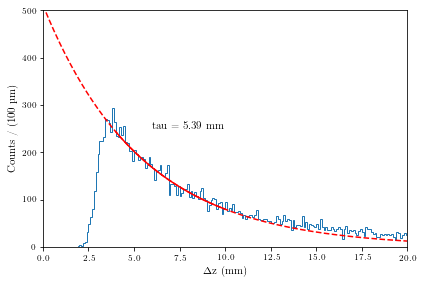

In [11]:
_d = x.d
_d = _d[(_d['largest_other_s2']) > 100]
_d['dz'] = 100 / (59.3 - 1.5) * 0.001 * abs(_d['largest_other_s2_center_time'] - _d['s2_center_time'])
def exp_decay(x, a0, tau):
    return a0 * np.exp(-x / tau)
counts, bin_edges = np.histogram(_d['dz'], bins=200, range=(0, 20))
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
fit_range  = (4, 10)
x_fit = bin_centers[(bin_centers >= fit_range[0]) & (bin_centers < fit_range[1])]
y_fit = counts[(bin_centers >= fit_range[0]) & (bin_centers < fit_range[1])]
y_err = np.sqrt(y_fit)
popt_dz, pcov_dz = scipy.optimize.curve_fit(exp_decay, x_fit, y_fit, sigma = y_err, p0=[500, 10])


predicted_counts = [exp_decay(_x, *popt_dz) for _x in np.linspace(0, 10, 100)]
print('Predicted number of counts 0-10 mm: %d' % sum(predicted_counts))
actual_counts = sum(_d['dz'] < 10)
print('Actual number of counts 0-10 mm: %d' % actual_counts)

plt.hist(100 / (59.3 - 1.5) * 0.001 *abs(_d['largest_other_s2_center_time'] - _d['s2_center_time']), histtype='step', bins=200, 
         range=(0, 20))
x_fit_range = np.linspace(*fit_range, num = 50)
x_plot = np.linspace(0, 20, 200)
plt.plot(x_plot, exp_decay(x_plot, *popt_dz), ls='--', color='red')
plt.plot(x_fit_range, exp_decay(x_fit_range, *popt_dz), ls='solid', color='red')
plt.xlabel(r'$\Delta$z (\si{mm})')
plt.xlim(0, 20)
plt.ylabel(r'Counts / (\SI{100}{\micro m})')
plt.ylim(0, 500)
plt.text(6, 250, 'tau =  %.2f mm'% popt_dz[1])

plt.show()

largest_other_s2 below 100 selection: 19690 rows removed (75.97% passed)


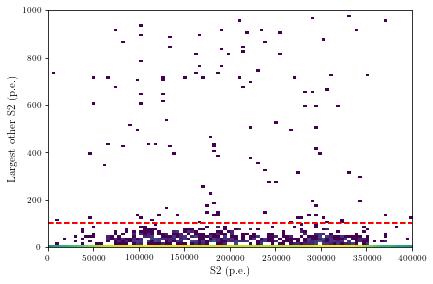

In [12]:
x.cut_largest_other_s2(largest_other_s2_max=100, 
                       plot=True, apply=True, bins=100, norm=LogNorm(), range=((0, 400e3), (0, 1000)))

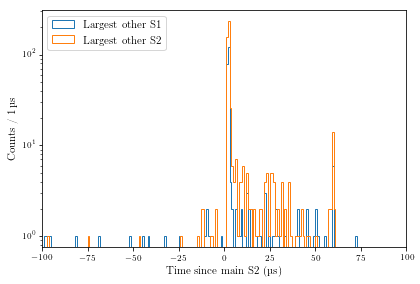

0.00422381395946
0.00881701088877


In [13]:
_d = x.d
plt.hist((_d['largest_other_s1_center_time'] - _d['s2_center_time'])*1e-3, 
         bins=200, histtype='step', range=(-100, 100), label='Largest other S1')
plt.hist((_d['largest_other_s2_center_time'] - _d['s2_center_time'])*1e-3, 
         bins=200, histtype='step', range=(-100, 100), label='Largest other S2')
plt.xlabel(r'Time since main S2 (\si{\micro s})')
plt.ylabel(r'Counts / \SI{1}{\micro s}')
plt.yscale('log')
plt.xlim(-100, 100)
plt.legend(loc='upper left')
plt.show()

print(sum(_d['largest_other_s1'] > 0) / len(_d))
print(sum(_d['largest_other_s2'] > 0) / len(_d))

### S2 width

Cutoff at 251.5 ns


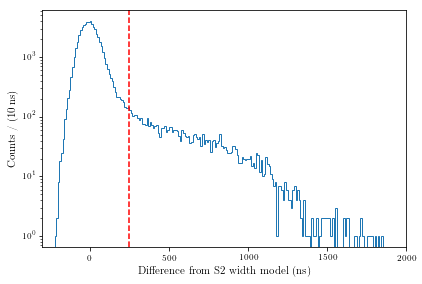

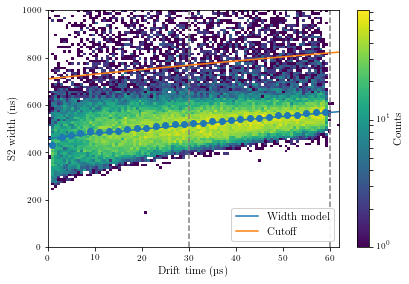

s2_width_difference below 251.5 selection: 4358 rows removed (93.00% passed)


In [14]:
x.cut_s2_range_50p_area(apply = True, plot=True, pickle_file='data/cs137_s2_width.pickle')

In [15]:
n_counts_left = sum(predicted_counts) - actual_counts - 4358

In [16]:
n_counts_left

7064.6963545017825

In [17]:
a0  = popt_dz[0]
tau = popt_dz[1]
bin_width = 0.1
# This number should be close to predicted counts
a0*tau*(1 - np.exp(- 10./tau)) / bin_width

# ACTUAL ESTIMATED RESOLVING POWER S2S in mm
- tau * np.log(1 - n_counts_left * 0.1/(a0 * tau))

1.5972902024739053

### Drift time

drift_time in [0, 62) selection: 1 rows removed (100.00% passed)


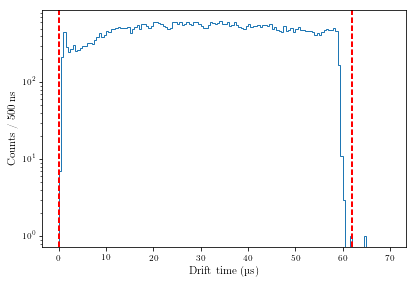

In [18]:
x.cut_drift_time(apply=True, plot=True, range=(0, 70), drift_time_bounds=(0, 62), bins=140, histtype='step')
plt.yscale('log')
plt.xlabel(r'Drift time (\si{\micro s})')
plt.ylabel(r'Counts / \SI{500}{\nano s}')

### Apply S1 and S2 corrections from Cs

In [19]:
# Use the Na-22 derived LCE correction
x.corr_s1_ly_poly(ly_filename='data/cs137_ly_p2_rough.pickle')
x.corr_s2_electron_lifetime(pickle_file='data/cs137_electron_lifetime_rough.pickle')

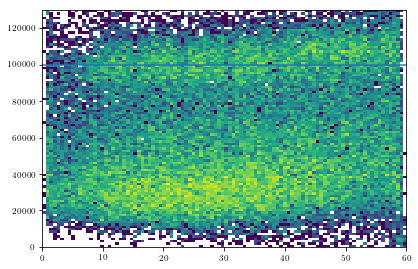

In [20]:
# plt.hist2d(x.d['drift_time'], x.d['s2_bot'], norm=LogNorm(), bins=100, range=((0, 60), (0, 130e3)))
plt.hist2d(x.d['drift_time'], x.d['cs2b'], norm=LogNorm(), bins=100, range=((0, 60), (0, 130e3)))
plt.axhline(100e3)
plt.show()

## Fit

#### Photopeak selection

In [21]:
cs1_range = (1100, 2200)
cs2_range = (75e3, 125e3)
cs1_bins = 40
cs2_bins = 40

In [22]:
def cut1(x):
    return 142e3 - 40*x   
def cut2(x):
    return 190e3 - 40*x  

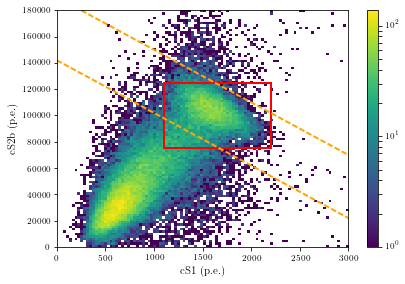

In [23]:
x.plot_cs1cs2b(bins=100, norm=LogNorm(), range=((0, 3000), (0, 180e3)))
plt.colorbar()
draw_box(cs1_range, cs2_range, edgecolor='red', lw=2)
x_plot = np.linspace(0, 3000, 20)
plt.plot(x_plot, cut1(x_plot), color='orange', lw=2, ls='--')
plt.plot(x_plot, cut2(x_plot), color='orange', lw=2, ls='--')

#### Build lists

In [24]:
d = x.d

In [25]:
counts, x_fit, y_fit = build_fit_lists(d['cs1'], d['cs2b'], cs1_range, cs2_range, cs1_bins, cs2_bins)

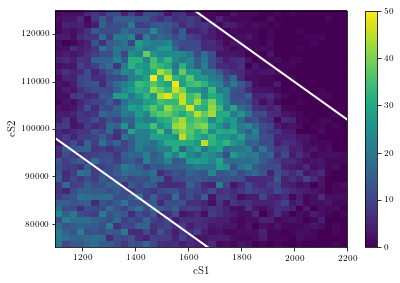

In [26]:
plt.hist2d(d['cs1'], d['cs2b'], bins=(cs1_bins, cs2_bins), range=(cs1_range, cs2_range))#, norm=LogNorm())

x_plot = np.linspace(*cs1_range, num=20)
for cut in [cut1, cut2]:
    plt.plot(x_plot, cut(x_plot), color='white', lw=2)
plt.colorbar()
plt.xlabel('cS1')
plt.ylabel('cS2')
plt.show()

In [27]:
sel = (cut1(x_fit) < y_fit) & (cut2(x_fit) > y_fit)

In [28]:
initial_guess = (30,1500,100000,30,2000,-0.03,0)
popt, pcov = scipy.optimize.curve_fit(twoD_Gaussian, (x_fit[sel], y_fit[sel]), counts[sel], p0=initial_guess)
print('cS1 peak position: %.1f' % (popt[1]))
print('cS2 peak position: %.1f' % (popt[2]))
print(popt)
theta = popt[-2]
slope = np.tan(theta)
# pickle.dump()

cS1 peak position: 1563.1
cS2 peak position: 104371.6
[  3.80935008e+01   1.56309461e+03   1.04371557e+05   1.77342706e+02
   1.10341294e+04  -7.07891893e-03   1.46570320e+00]


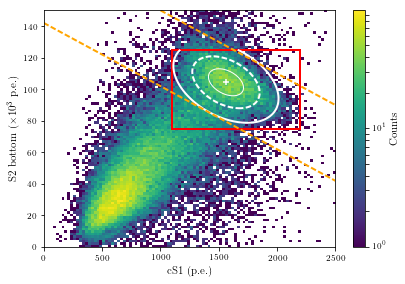

In [29]:
x.plot_cs1cs2b(bins=100, norm=LogNorm(), range=((0, 2500), (0, 150e3)))
plt.colorbar(label='Counts')
draw_box(cs1_range, cs2_range, edgecolor='red', lw=2)
x_plot = np.linspace(0, 3000, 20)
plt.plot(x_plot, cut1(x_plot), color='orange', lw=2, ls='--')
plt.plot(x_plot, cut2(x_plot), color='orange', lw=2, ls='--')
# Draw contours at 0.5, 1 and 1.5 sigma
gaus_max = popt[0]
sigma_levels = [gaus(1.5, gaus_max, 0, 1), gaus(1, gaus_max, 0, 1), gaus(0.5, gaus_max, 0, 1)]
plot2d(twoD_Gaussian, popt, (1000, 2600), cs2_range, 4, 40, levels=sigma_levels, 
       colors=['white', 'white', 'white'],
       linewidths = [2,2,1],
       linestyles = ['solid', 'dashed', 'solid'],
      )
plt_divide_axis('y', 1000)
plt.ylabel(r'S2 bottom ($\times 10^3$ p.e.)')
plt.scatter(popt[1], popt[2], marker = '+', color='white')

In [30]:
pickle.dump((popt, pcov), open('data/na22_s1s2fit_2d_rough.pickle', 'wb'))

## Photopeak selection 'sel0' 

### Select photopeak

This is actually a little tricky... We want the same selection as Cs, which means: using the correction of one before, i.e. using old cs1, cs2b, g1, g2, THEN select photopeak, THEN apply the newer selection. Only then are we compatible with the other calibration! 

In [59]:
iteration_number = 2

# Load cs1 and cs2 from previous calibration
if iteration_number == 0:
    x.corr_s1_ly_poly(ly_filename='data/cs137_ly_p2_rough.pickle')
    x.corr_s2_electron_lifetime(pickle_file='data/cs137_electron_lifetime_rough.pickle')
    x.add_g1g2_props(pickle_file='data/doke_rough.pickle')
else:
    x.corr_s1_ly_poly(ly_filename='data/cs137_ly_p2_sel%d.pickle' % (iteration_number - 1))
    x.corr_s2_electron_lifetime(pickle_file='data/cs137_electron_lifetime_sel%d.pickle' % (iteration_number - 1))
    x.add_g1g2_props(pickle_file='data/doke_sel%d.pickle' % (iteration_number - 1))

-2553.58382549


/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:20: InitialParamWarning: errordef is not given. Default to 1.
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:20: InitialParamWarning: Parameter a0 is floating but does not have initial step size. Assume 1.
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:20: InitialParamWarning: Parameter mu is floating but does not have initial step size. Assume 1.
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:20: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:20: InitialParamWarning: Parameter off is floating but does not have initial step size. Assume 1.
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:20: InitialParamWarning: Parameter slope is floating but does not 

FCN = -2776.7141867363202 
 TOTAL NCALL = 251 
 NCALLS = 251 
 
 
 EDM = 1.636471060599849e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,a0,237.504,26.0784,0,0,,,
2,mu,514.868,0.619373,0,0,,,
3,sigma,33.4118,0.978659,0,0,,,
4,off,326.627,19.3623,0,0,,,
5,slope,-0.529963,0.0314265,0,0,,,


0.06489389050883737


(0, 1200)

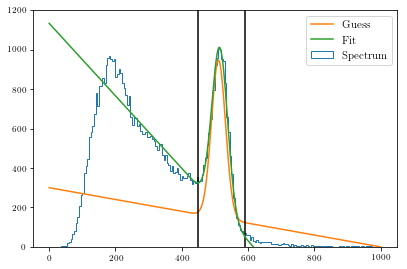

In [60]:
popt_ces, m_ces, norm = fit_gaus_with_bg(x.d['e_ces'].values, (450, 590), 800, 511,  30, 300, -0.3)
plt.ylim(0, 1200)

In [61]:
sigmas_to_select = 1.5

energy_range = (m_ces.values['mu'] - sigmas_to_select * m_ces.values['sigma'], 
                m_ces.values['mu'] + sigmas_to_select * m_ces.values['sigma'])
pp = cuts.range_selection(x.d, 'e_ces', energy_range)

e_ces in [464.7503803639215, 564.9857565463988) selection: 44603 rows removed (22.97% passed)


### Apply the newer correction!

In [62]:
x.corr_s1_ly_poly(ly_filename='data/cs137_ly_p2_sel%d.pickle' % iteration_number)
x.corr_s2_electron_lifetime(pickle_file='data/cs137_electron_lifetime_sel%d.pickle' % iteration_number, verbose=True)

Using lifetime 810.658412


### Fit S1

e_ces in [481.4562763943344, 548.2798605159859) selection: 47104 rows removed (18.66% passed)
[1578.2351471279405, 254.36959127349058]
e_ces in [481.4562763943344, 548.2798605159859) selection: 47104 rows removed (18.66% passed)
[1583.4373551536912, 260.5754732275359]
e_ces in [481.4562763943344, 548.2798605159859) selection: 47104 rows removed (18.66% passed)
[1585.895746845901, 261.93190457487566]
e_ces in [464.7503803639215, 564.9857565463988) selection: 44603 rows removed (22.97% passed)
[1569.5099535362594, 270.16912908721935]
e_ces in [464.7503803639215, 564.9857565463988) selection: 44603 rows removed (22.97% passed)
[1573.6867521975207, 271.9506421132805]
e_ces in [464.7503803639215, 564.9857565463988) selection: 44603 rows removed (22.97% passed)
[1577.8950299567668, 275.85331279529555]
e_ces in [448.04448433350865, 581.6916525768116) selection: 43083 rows removed (25.60% passed)
[1556.7266589268518, 276.6846013232023]
e_ces in [448.04448433350865, 581.6916525768116) selection

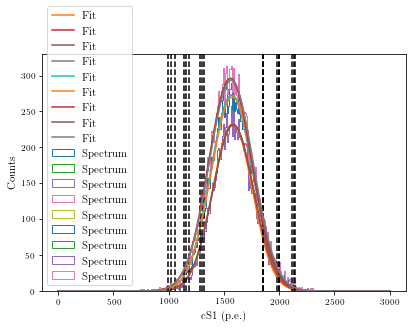

In [63]:
popts = []

# Scan different peak selections
for sigmas_to_select in [1.0, 1.5, 2.0]:
    for sigmas_to_select_cs1 in [1.0, 1.5, 2.0]:
    
        # re-select energies
        energy_range = (m_ces.values['mu'] - sigmas_to_select * m_ces.values['sigma'], 
                        m_ces.values['mu'] + sigmas_to_select * m_ces.values['sigma'])
        d = x.d
        pp = cuts.range_selection(d, 'e_ces', energy_range)

        popt_cs1_it0, _ , _ =  fit_gaus(pp['cs1'], (1000, 2500), 1500, 200, (0, 3000), 300, plot=False, print_level=0)
        popt_cs1_it1, m_cs1_it1 , _ =  fit_gaus(pp['cs1'], (popt_cs1_it0[0] - sigmas_to_select_cs1 * popt_cs1_it0[1], 
                                             popt_cs1_it0[0] + sigmas_to_select_cs1 * popt_cs1_it0[1])
                                 , popt_cs1_it0[0], popt_cs1_it0[1], (0, 3000), 300, print_level = 0, plot_guess=False)
        plt.xlabel('cS1 (p.e.)')
        plt.ylabel('Counts')
        print(popt_cs1_it1)
        popts.append([sigmas_to_select, sigmas_to_select_cs1] + popt_cs1_it1)

e_ces in [464.7503803639215, 564.9857565463988) selection: 44603 rows removed (22.97% passed)
[1573.6867521975207, 271.9506421132805]


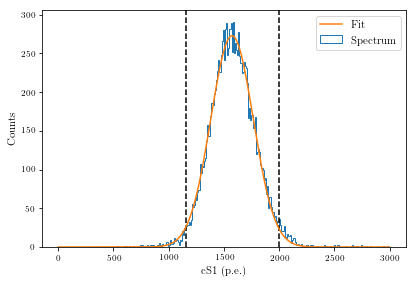

In [64]:
sigmas_to_select = 1.5
sigmas_to_select_cs1 = 1.5
    
# re-select energies
energy_range = (m_ces.values['mu'] - sigmas_to_select * m_ces.values['sigma'], 
                m_ces.values['mu'] + sigmas_to_select * m_ces.values['sigma'])
d = x.d
pp = cuts.range_selection(d, 'e_ces', energy_range)

popt_cs1_it0, _ , _ =  fit_gaus(pp['cs1'], (1000, 2500), 1500, 200, (0, 3000), 300, plot=False, print_level=0)
popt_cs1_it1, m_cs1_it1 , _ =  fit_gaus(pp['cs1'], (popt_cs1_it0[0] - sigmas_to_select_cs1 * popt_cs1_it0[1], 
                                     popt_cs1_it0[0] + sigmas_to_select_cs1 * popt_cs1_it0[1])
                         , popt_cs1_it0[0], popt_cs1_it0[1], (0, 3000), 300, print_level = 0, plot_guess=False)
plt.xlabel('cS1 (p.e.)')
plt.ylabel('Counts')
print(popt_cs1_it1)


In [65]:
popt_s1 = m_cs1_it1.values
perr_s1 = m_cs1_it1.errors
perr_s1_syst = np.std(np.array(popts)[:,2])

In [66]:
(popt_s1, perr_s1, perr_s1_syst)

({'mu': 1573.6867521975207, 'sigma': 271.9506421132805},
 {'mu': 2.6390925205775972, 'sigma': 3.3870985376878155},
 9.1362022953238782)

In [67]:
pickle.dump((popt_s1, perr_s1, perr_s1_syst), open('data/na22_s1_sel%d.pickle' % iteration_number, 'wb'))

### Fit S2

e_ces in [481.4562763943344, 548.2798605159859) selection: 47104 rows removed (18.66% passed)
[100452.88239676984, 13558.0173227385]
e_ces in [481.4562763943344, 548.2798605159859) selection: 47104 rows removed (18.66% passed)
[100712.63248467736, 13573.445995563283]
e_ces in [481.4562763943344, 548.2798605159859) selection: 47104 rows removed (18.66% passed)
[100804.98442076228, 13688.005981822253]
e_ces in [464.7503803639215, 564.9857565463988) selection: 44603 rows removed (22.97% passed)
[99951.91486014017, 14054.019170691427]
e_ces in [464.7503803639215, 564.9857565463988) selection: 44603 rows removed (22.97% passed)
[100309.39649051485, 14098.266612277892]
e_ces in [464.7503803639215, 564.9857565463988) selection: 44603 rows removed (22.97% passed)
[100532.9321343221, 14468.9746698866]
e_ces in [448.04448433350865, 581.6916525768116) selection: 43083 rows removed (25.60% passed)
[99452.54539472464, 14454.487466090071]
e_ces in [448.04448433350865, 581.6916525768116) selection: 4

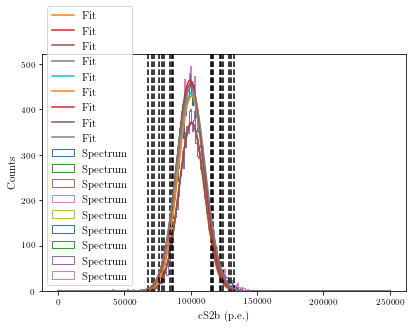

In [68]:
popts = []

# Scan different peak selections
for sigmas_to_select in [1.0, 1.5, 2.0]:
    for sigmas_to_select_cs2 in [1.0, 1.5, 2.0]:   
        # re-select energies
        energy_range = (m_ces.values['mu'] - sigmas_to_select * m_ces.values['sigma'], 
                        m_ces.values['mu'] + sigmas_to_select * m_ces.values['sigma'])
        d = x.d
        pp = cuts.range_selection(d, 'e_ces', energy_range)

        popt_cs2_it0, _ , _ =  fit_gaus(pp['cs2b'],  (50e3, 160e3), 90e3, 15e3, (0, 250e3), 300, int_step=10
                                        , plot=False, print_level=0)
        popt_cs2_it1, m_cs2_it1 , _ =  fit_gaus(pp['cs2b'], (popt_cs2_it0[0] - sigmas_to_select_cs2 * popt_cs2_it0[1], 
                                             popt_cs2_it0[0] + sigmas_to_select_cs2 * popt_cs2_it0[1])
                                 , popt_cs2_it0[0], popt_cs2_it0[1], 
                                                (0, 250e3), 300, int_step=10, print_level = 0, plot_guess=False)
        plt.xlabel('cS2b (p.e.)')
        plt.ylabel('Counts')
        print(popt_cs2_it1)
        popts.append([sigmas_to_select, sigmas_to_select_cs2] + popt_cs2_it1)

e_ces in [464.7503803639215, 564.9857565463988) selection: 44603 rows removed (22.97% passed)


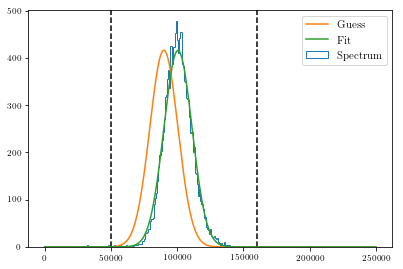

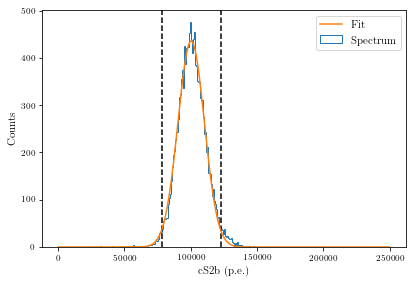

In [69]:
sigmas_to_select = 1.5
sigmas_to_select_cs2 =1.5
# re-select energies
energy_range = (m_ces.values['mu'] - sigmas_to_select * m_ces.values['sigma'], 
                m_ces.values['mu'] + sigmas_to_select * m_ces.values['sigma'])
d = x.d
pp = cuts.range_selection(d, 'e_ces', energy_range)

popt_cs2_it0, _ , _ =  fit_gaus(pp['cs2b'],  (50e3, 160e3), 90e3, 15e3, (0, 250e3), 300, int_step=10
                                , plot=True, print_level=0)
plt.show()
popt_cs2_it1, m_cs2_it1 , _ =  fit_gaus(pp['cs2b'], (popt_cs2_it0[0] - sigmas_to_select_cs2 * popt_cs2_it0[1], 
                                     popt_cs2_it0[0] + sigmas_to_select_cs2 * popt_cs2_it0[1])
                         , popt_cs2_it0[0], popt_cs2_it0[1], 
                                        (0, 250e3), 300, int_step=10, print_level = 0, plot_guess=False)
plt.xlabel('cS2b (p.e.)')
plt.ylabel('Counts')

In [70]:
popt_s2 = m_cs2_it1.values
perr_s2 = m_cs2_it1.errors
perr_s2_syst = np.std(np.array(popts)[:,2])

In [71]:
(popt_s2, perr_s2, perr_s2_syst)

({'mu': 100309.39649051485, 'sigma': 14098.266612277892},
 {'mu': 134.7851023003317, 'sigma': 168.00128794807947},
 432.41558838223398)

In [72]:
pickle.dump((popt_s2, perr_s2, perr_s2_syst), open('data/na22_s2_sel%d.pickle' % iteration_number, 'wb'))